In [1]:
import sqlite3
import numpy as np
import pandas as pd
import joblib
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, \
                        precision_score, accuracy_score, recall_score, auc


DB_NAME='rxn_db.sql'
domains = ["amides", "sulfonamides", "heterocycles", "alkyl amines","anilines",  
           "ROH", "ArOH", "ArSH", "malonates", "Bpin"]
new_domains = ["amide", "sulfonamide", "heterocycles", "alkyl amines","aniline",  
           "ROH", "ArOH", "ArSH", "malonate", "Bpin"]
tables = ["Nucleophiles", "Electrophiles", "Catalysts","Bases", "Solvents"]
N_nucs = domains[:2]+["ROH"]+domains[2:5]

In [2]:
def find_inds_of_conds(id_array1, id_array2):
    ''' Finds row indices for rxn conditions that are common
    between two domains.
    
    Parameters
    ----------
    id_array1, id_array2 : np.2darrays
        reaction array with component ids.
    
    Returns
    -------
    common_conditions_and_inds : dict
        key : rxn condition tuple with ids (elec, cat, base, solv).
        val : list of row indices, for each domain of condition.
    '''
    conds = np.concatenate(
               (id_array1[:,1:],
                id_array2[:,1:]),
                axis=0
            )
    unique_conditions = np.unique(conds, axis=0)
    inds_for_condition = {}
    for row in unique_conditions:
        inds_for_condition.update({tuple(row):[]})
    for i, row in enumerate(id_array1):
        inds_for_condition[tuple(row[1:])].append(i)
    for j, row in enumerate(id_array2):
        inds_for_condition[tuple(row[1:])].append(j)
            
    common_conditions_and_inds = {}
    for key, val in inds_for_condition.items():
        if len(val)==2:
            common_conditions_and_inds.update({key:val})
    print(f"    {len(common_conditions_and_inds.keys())} rxns with common conditions")
    return common_conditions_and_inds


def extract_common_array(id_array1, desc_array1, y_array1,
                         id_array2, desc_array2, y_array2,
                         common_conditions_and_inds):
    ''' Prepares arrays with common rxn conditions, to be used
    as a test set for direct model transfer.'''
    num_rxns = len(common_conditions_and_inds.keys())
    common_id_array1 = np.zeros((num_rxns,5))
    common_id_array2 = np.zeros_like(common_id_array1)
    common_desc_array1 = np.zeros((num_rxns, desc_array1.shape[1]))
    common_desc_array2 = np.zeros_like(common_desc_array1)
    common_y_array1 = np.zeros(num_rxns)
    common_y_array2 = np.zeros(num_rxns)
    
    row_count = 0
    for k, v in common_conditions_and_inds.items():
        assert np.sum(id_array1[v[0],1:] - np.array(k))==0
        assert np.sum(id_array2[v[1],1:] - np.array(k))==0
        common_id_array1[row_count,:] = id_array1[v[0],:]
        common_id_array2[row_count,:] = id_array2[v[1],:]
        common_desc_array1[row_count,:] = desc_array1[v[0],:]
        common_desc_array2[row_count,:] = desc_array2[v[1],:]
        common_y_array1[row_count] = y_array1[v[0]]
        common_y_array2[row_count] = y_array2[v[1]]
        row_count += 1
    return common_id_array1, common_desc_array1, common_y_array1,\
           common_id_array2, common_desc_array2, common_y_array2

In [3]:
def train_source_model(source_X, source_y, 
                       param_grid={"n_estimators":[25,50,100],
                                   "max_depth":[2,5,None]}, 
                       cycle=10, cv=5, scoring="roc_auc", 
                       random_state=42):
    ''' Prepares source models based on random splitting and grid-search CV.
    
    Parameters
    ----------
    source_X, source_y : np.2d/1d array
       reaction array / yield array
    model : sklearn classifier
    param_grid : dict
        dictionary of hyperparameters to search across
    cycle : int
        number of models to train
    cv : int
        number of cross validation splits
    scoring : str
        performance metric
        
    Returns
    -------
    source_models : list
        list of trained classifiers with length=cycle
    X_test_list / y_test_list : list
        list of splitted test set input/label
    '''
    source_models = []
    X_test_list = []
    y_test_list = []
    auc_list = []
    
    cv = 5  # all domains have more than 5 negative rxns
    test_size=0.2
    for k in range(cycle) :
        X_source_train, X_source_test, y_source_train, y_source_test = train_test_split(
                        source_X, source_y, random_state=random_state+k, test_size=test_size,
                        stratify=source_y)
        X_test_list.append(X_source_test)
        y_test_list.append(y_source_test)
        grid_rfc = GridSearchCV(RandomForestClassifier(random_state=random_state+k),
                                param_grid=param_grid, 
                                scoring=scoring, cv=cv)
        grid_rfc.fit(X_source_train, y_source_train)
        opt_rfc = grid_rfc.best_estimator_
        source_models.append(opt_rfc)
        test_proba = opt_rfc.predict_proba(X_source_test)
        auc_list.append(
            round(roc_auc_score(y_source_test, test_proba[:,1]),3)
        )
    print("AUC values: ", auc_list)
    avg = sum(auc_list)/len(auc_list)
    print(f"average: {avg.round(3)}")
    print()
    return source_models, X_test_list, y_test_list


def pairwise_transfer(id_array_dict, desc_array_dict,
                      y_array_dict, list_of_nucs, 
                      cycle=10, scoring="roc_auc", 
                      param_grid={"n_estimators":[25,50,100],
                                   "max_depth":[2,5,None]},
                      cv=5, random_state=42):
    ''' Trains models over multiple domains.
    
    Parameters
    ----------
    id_array_dict / desc_array_dict / y_array_dict : dict
        key : domain
        value : reaction np.2darrays / yield np.1darray
    list of nucs : list of str
        list of domain names to transfer between
    cycle : int
        number of models to train
    scoring : str
        performance metric upon which the model is trained.
    param_gird: dict
        parameters to optimize RandomForestClassifier across.
    cv : int
    random_state: int
    
    Returns
    -------
    source_models_list, list_of_X_test_lists, list_of_y_test_lists : list of lists
        list of models, splitted test input and output labels in the order of domain
    target_arrays : list of lists
        when transferring from nuc-i to nuc-j :
            performance should be measured on target_arrays[i][j]
    '''
    source_models_list = []
    list_of_X_test_lists = []
    list_of_y_test_lists = []
    target_arrays = [["_"]*len(list_of_nucs) for x in range(len(list_of_nucs))]

    for i, source in enumerate(list_of_nucs):
        # Preparing source models and test arrays
        print(f"Preparing models and arrays for {source}.")
        source_X = desc_array_dict[source]
        source_id = id_array_dict[source]
        source_y = y_array_dict[source]
        source_models, X_test_list, y_test_list = train_source_model(source_X, source_y)
        source_models_list.append(source_models)
        list_of_X_test_lists.append(X_test_list)
        list_of_y_test_lists.append(y_test_list)
        
        for j, target in enumerate(list_of_nucs):
            if i<j :
                target_X = desc_array_dict[target]
                target_id = id_array_dict[target]
                target_y = y_array_dict[target]
                common_conditions_and_inds = find_inds_of_conds(source_id, target_id)
                _, common_source_desc, common_source_y,\
                _, common_target_desc, common_target_y = extract_common_array(
                                 source_id, source_X, source_y,
                                 target_id, target_X, target_y,
                                 common_conditions_and_inds)
                target_arrays[i][j] = (common_target_desc, common_target_y)
                target_arrays[j][i] = (common_source_desc, common_source_y)
    return source_models_list, list_of_X_test_lists, list_of_y_test_lists, target_arrays


def trellis_of_transfer_ROC(source_models_list, list_of_X_test_lists, 
                            list_of_y_test_lists, 
                            target_arrays, list_of_nuc, 
                            cycle=10, save=False):
    ''' Prepares a 3x3 trellis plot of ROC-curves for 
    models transferred between three domains. 
    
    Parameters
    ----------
    source_models_list, list_of_X_test_lists,\
    list_of_y_test_lists, target_arrays : outputs of function above.
    
    cycle : int
        number of source models trained.
    save : bool
        whether to save resulting figure.
    
    Returns
    -------
    None
    '''
    num_nucs = len(list_of_nuc)
    
    # Initializing plots
    fig = plt.figure(figsize=(8,8), constrained_layout=False)
    outer_grid = fig.add_gridspec(num_nucs, num_nucs, wspace=0.05, hspace=0.05)
    
    for i, source_nuc in enumerate(list_of_nuc):
        source_models = source_models_list[i]
        for j, target_nuc in enumerate(list_of_nuc):
            if i==j :
                target_X_list, target_y_list = list_of_X_test_lists[i], list_of_y_test_lists[i]
            else :
                target_X, target_y = target_arrays[i][j][0], target_arrays[i][j][1]
            
            target_aucs = np.zeros(cycle)
            tprs, aucs = [], []
            mean_fpr = np.linspace(0,1,100)
            axs = fig.add_subplot(outer_grid[i,j])
            for k in range(cycle):
                opt_rfc = source_models[k]
                if i==j : 
                    target_X = target_X_list[k]
                    target_y = target_y_list[k]
                    color = '#404788'
                else : 
                    color = '#20A387'
                target_proba = opt_rfc.predict_proba(target_X)
                target_aucs[k] = roc_auc_score(target_y, target_proba[:,1])
                # Draws one ROC Curve for each model
                viz = plot_roc_curve(opt_rfc, target_X, target_y,
                                     alpha=0.2, lw=1, color=color, ax=axs)
                interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
                interp_tpr[0]=0.0
                tprs.append(interp_tpr)
                aucs.append(viz.roc_auc)
                tprs.append(interp_tpr)
            # Draws the average ROC curve    
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1
            mean_auc = auc(mean_fpr, mean_tpr)
            plt.plot(mean_fpr, mean_tpr, color=color, lw=2, alpha=.8)
            axs.get_legend().remove()
            axs.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
            if i==0 and j==0:
                axs.text(x=0.45,y=0.02,s=f"AUC:{mean_auc.round(3)}",
                         fontsize=14)
            else : 
                axs.text(x=0.7,y=0.02,s=f"{mean_auc.round(3):0<5}",
                         fontsize=14)
            axs.plot([0,1],[0,1], linestyle='--', lw=2, color='r', 
                    label='Random', alpha=0.5)
            if (i<2) and (j>0): # remove ticklabels for inner plots
                axs.set_xlabel('')
                axs.set_ylabel('')
                axs.set_xticks([0.0, 0.5, 1.0])
                axs.get_xaxis().set_ticklabels([])
                axs.get_yaxis().set_ticklabels([])
            if (i==2):
                axs.set_xticks([0.0, 0.5, 1.0])
                axs.set_xticklabels([0.0, 0.5, 1.0])
                if j == 0 :
                    axs.set_xlabel('\n\nAmides', fontsize=12)
                else :  
                    axs.set_ylabel('')
                    axs.get_yaxis().set_ticklabels([])
                    if j == 1 :
                        axs.set_xlabel(r"$\bf{"+'False\ Positive\ Rate'+"}$"+ "\n\nSulfonamides\n\n" +  r"$\bf{"+ 'Target\ Nucleophile'+ "}$",
                                      fontsize=12)
                    else :
                        axs.set_xlabel('\n\nBpin',
                                      fontsize=12)
            if j == 0 :
                axs.set_yticks([0.0, 0.5, 1.0])
                axs.set_yticklabels([0.0, 0.5, 1.0])
                if i == 0 :
                    axs.set_xlabel('')
                    axs.set_ylabel('Amides\n\n',
                                  fontsize=12)
                elif i == 1 :
                    axs.set_xlabel('')
                    axs.set_ylabel(r"$\bf{"+"Source\ Nucleophile"+"}$" + "\n\nSulfonamides\n\n" + r"$\bf{"+ "True\ Positive\ Rate" + "}$",
                                  fontsize=12)
                else :
                    axs.set_xticks([0.0, 0.5, 1.0])
                    axs.set_ylabel('Bpin\n\n', fontsize=12)
            if i==0 and j==2 :
                custom_lines = [Line2D([0], [0], color='#404788', lw=4),
                                Line2D([0], [0], color='#20A387', lw=4),
                                Line2D([0], [0], color='red', lw=4)]
                axs.legend(custom_lines, ['Cross Validation', 'Transfer', 'Random'], 
                           loc='upper left', fontsize=10)

    if save:
        fig.savefig(f'./figures/figure3.pdf', format="pdf", dpi=300, 
            bbox_inches="tight")

In [4]:
full_id = joblib.load('./array_joblibs/full_id_arrays_by_nuc.joblib')
full_desc = joblib.load('./array_joblibs/full_desc_arrays_by_nuc.joblib')
full_yield = joblib.load('./array_joblibs/full_y_arrays_by_nuc.joblib')

## Preliminary Transfer Experiment

In [5]:
source_models_list, list_of_X_test_lists,\
list_of_y_test_lists, target_arrays = pairwise_transfer(
                     full_id, full_desc,
                     full_yield, ["amides", "sulfonamides", "Bpin"]
)

Preparing models and arrays for amides.
AUC values:  [0.931, 0.851, 0.917, 0.778, 0.833, 0.979, 0.958, 0.833, 0.892, 0.938]
average: 0.891

    124 rxns with common conditions
    50 rxns with common conditions
Preparing models and arrays for sulfonamides.
AUC values:  [0.994, 0.949, 1.0, 0.955, 0.987, 0.936, 0.936, 0.872, 0.83, 0.981]
average: 0.944

    50 rxns with common conditions
Preparing models and arrays for Bpin.
AUC values:  [0.875, 0.792, 0.792, 0.854, 0.917, 1.0, 1.0, 1.0, 0.75, 1.0]
average: 0.898



In [10]:
sulfon_feature_importances = np.zeros((len(source_models_list[1]), 73))
for i, sulfon_model in enumerate(source_models_list[1]) :
    sulfon_feature_importances[i,:] = sulfon_model.feature_importances_

In [11]:
np.mean(sulfon_feature_importances, axis=0)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00506997, 0.0021845 , 0.00084099, 0.00577501,
       0.00778411, 0.0034325 , 0.0033318 , 0.00516394, 0.00536168,
       0.00281775, 0.00409865, 0.00620164, 0.00589887, 0.00343304,
       0.00520524, 0.00344681, 0.00382151, 0.00716331, 0.00431995,
       0.00585035, 0.0018282 , 0.00447616, 0.0042756 , 0.00670794,
       0.00356046, 0.00363462, 0.00208628, 0.09037323, 0.04405898,
       0.01852032, 0.02089822, 0.05212582, 0.12211664, 0.0236621 ,
       0.00778492, 0.01187289, 0.01791402, 0.01839643, 0.01966835,
       0.04888966, 0.01949253, 0.01288978, 0.03223923, 0.0337912 ,
       0.01444617, 0.0148144 , 0.01086194, 0.02572554, 0.00868149,
       0.03979837, 0.00985165, 0.0119606 , 0.02652269, 0.00588987,
       0.0125793 , 0.00700405, 0.00884196, 0.00695094, 0.00691383,
       0.00767361, 0.01013446, 0.00904488, 0.00898497, 0.01165276,
       0.00906781, 0.00994032, 0.01019318])

In [12]:
bpin_feature_importances = np.zeros((len(source_models_list[2]), 73))
for i, bpin_model in enumerate(source_models_list[2]) :
    bpin_feature_importances[i,:] = bpin_model.feature_importances_

In [16]:
bpin_feature_importances[:,:6]

array([[0.01719888, 0.00773776, 0.01064514, 0.00102297, 0.00517201,
        0.00692783],
       [0.00606634, 0.01037905, 0.01032628, 0.00576179, 0.00633342,
        0.0151927 ],
       [0.00536846, 0.00059659, 0.00842105, 0.00639906, 0.00539191,
        0.00645976],
       [0.04732358, 0.01225296, 0.0898175 , 0.0172888 , 0.02477086,
        0.01560193],
       [0.        , 0.01796234, 0.        , 0.        , 0.02177014,
        0.        ],
       [0.01833738, 0.0055255 , 0.00862544, 0.00894542, 0.00346861,
        0.00790332],
       [0.00583724, 0.01350591, 0.02651054, 0.        , 0.        ,
        0.        ],
       [0.        , 0.01296621, 0.00095238, 0.        , 0.01346939,
        0.04041235],
       [0.00531149, 0.00632231, 0.00348278, 0.00414201, 0.00427359,
        0.00617391],
       [0.        , 0.        , 0.0190852 , 0.        , 0.0123948 ,
        0.02284533]])

In [15]:
np.abs(np.mean(bpin_feature_importances, axis=0) - np.mean(sulfon_feature_importances, axis=0)) > 1e-2

array([ True, False,  True, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
        True, False, False,  True,  True,  True, False, False,  True,
       False,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False])

# source_models_list, list_of_X_test_lists

In [ ]:
list_of_y_test_lists, target_arrays = pairwise_transfer(
                     full_id, full_desc,
                     full_yield, ["amides", "sulfonamides", "Bpin"]
)

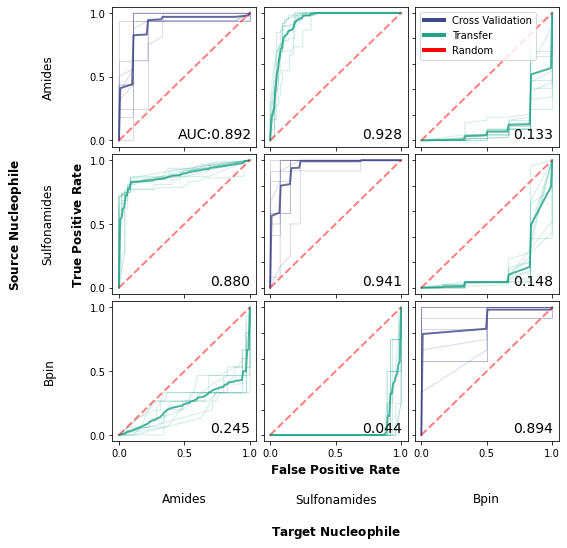

In [6]:
trellis_of_transfer_ROC(source_models_list, list_of_X_test_lists, 
                        list_of_y_test_lists, 
                        target_arrays, ["amides", "sulfonamides", "Bpin"],
                        save=False)

## Transfer between all pairs of domains

In [5]:
all_source_models_list, list_of_all_X_test_lists,\
list_of_all_y_test_lists, all_target_arrays = pairwise_transfer(
                     full_id, full_desc,
                     full_yield, domains
)

Preparing models and arrays for amides.
AUC values:  [0.931, 0.851, 0.917, 0.778, 0.833, 0.979, 0.958, 0.833, 0.892, 0.938]
average: 0.891

    124 rxns with common conditions
    99 rxns with common conditions
    99 rxns with common conditions
    99 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    50 rxns with common conditions
Preparing models and arrays for sulfonamides.
AUC values:  [0.994, 0.949, 1.0, 0.955, 0.987, 0.936, 0.936, 0.872, 0.83, 0.981]
average: 0.944

    99 rxns with common conditions
    99 rxns with common conditions
    99 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    112 rxns with common conditions
    50 rxns with common conditions
Preparing models and arrays for heterocycles.
AUC values:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.996, 1.0, 0.962, 1.0]

In [11]:
def performance_of_all_transfers(source_models_list, list_of_X_test_lists, 
                            list_of_y_test_lists, list_of_nuc, 
                            list_of_arrays,
                            cycle=10, scoring="roc_auc"):
    ''' For all pairs of nucleophile domains, measures ROC-AUC on
    reaction conditions that are common between the two domains.
    
    All inputs are output of function "pairwise_transfer()"
    
    Returns
    -------
    all_aucs, avg_aucs : np.2darrays
    '''
    # We skip normalization since RF doesn't need it
    num_nucs = len(list_of_nuc)
    all_aucs = {}
    avg_aucs = np.zeros((num_nucs, num_nucs))
    
    for i, source in enumerate(list_of_nuc):
        source_models = source_models_list[i]
        for j, target in enumerate(list_of_nuc):
            if i==j :
                target_X_list, target_y_list = list_of_X_test_lists[i], list_of_y_test_lists[i]
            else :
                target_X, target_y = list_of_arrays[i][j][0], list_of_arrays[i][j][1]
            target_aucs = np.zeros(cycle)
            for k in range(cycle):
                opt_rfc = source_models[k]
                if i==j : 
                    target_X = target_X_list[k]
                    target_y = target_y_list[k]
                target_proba = opt_rfc.predict_proba(target_X)
                target_pred = opt_rfc.predict(target_X)
                if scoring == "roc_auc" :
                    target_aucs[k] = roc_auc_score(target_y, target_proba[:,1])
                elif scoring == "accuracy" :
                    target_aucs[k] = accuracy_score(target_y, target_pred)
                elif scoring == "precision" :
                    target_aucs[k] = precision_score(target_y, target_pred)
                elif scoring == "recall" :
                    target_aucs[k] = recall_score(target_y, target_pred)
            all_aucs.update({f"{source}_to_{target}":target_aucs})
            avg_aucs[i,j] = np.average(target_aucs)
    return all_aucs, avg_aucs


def make_heatmap(list_of_nuc, avg_aucs, 
                palette='viridis', save=False):
    ''' Prepares a heatmap of all pairwise transfers.
    
    Parameters
    ----------
    list_of_nuc : list of str
        names of nucleophile domains
    avg_aucs : np.2darray
        output of function above, average transfer scores.
    palette : str
    save: bool
        whether to save the resulting figure
    
    Returns
    -------
    None
    '''
    target_avg_AUC_new = np.transpose(avg_aucs)
    AUC_data = {}
    for i, nuc in enumerate(list_of_nuc):
        AUC_data.update({nuc:target_avg_AUC_new[i,:]})
    AUC_data.update({"Source":list_of_nuc})

    AUC_df = pd.DataFrame(AUC_data).set_index("Source")
    AUC_df.index.name='Source'

    fig, ax = plt.subplots(figsize=(9, 6))
    ax = sns.heatmap(AUC_df, square=True, annot=True,
                     vmin=0, vmax=1, fmt='.2f', cmap=palette, cbar=False)
    ax.plot([0,8],[6,6], c='black', lw=2)
    #ax.plot([0,6],[8,8], c='black', linestyle='--')
    ax.plot([6,9],[8,8], c='black', lw=2)
    #ax.plot([9,10],[8,8], c='black', linestyle='--')
    ax.plot([8,10],[9,9], c='black', lw=2)
    
    ax.axvline(6,0.2,1.05, c='black', lw=2)
    #ax.axvline(8,0.4,1.05, c='black', linestyle='--')
    ax.axvline(8,0.1,0.4, c='black', lw=2)
    #ax.axvline(8,0,0.1, c='black') #, linestyle='--')
    ax.axvline(9,0,0.2, c='black', lw=2)
    ax.set_xlabel(r"$\bf{"+'Target\ Nucleophile'+"}$")
    ax.set_ylabel(r"$\bf{"+'Source\ Nucleophile'+"}$")
    ax.annotate("C-N Coupling", xy=(2,-0.1), xycoords='data',
                annotation_clip=False)
    ax.annotate("$S_{N}Ar$", xy=(6.5,-0.1), xycoords='data',
                annotation_clip=False)
    ax.annotate("C-C Coupling", xy=(8,-0.1), xycoords='data',
                annotation_clip=False)
    if save:
        fig.savefig("./figures/figure3B_diff_lines.pdf", format="pdf", dpi=300,
                    transparent=True, bbox_inches="tight")

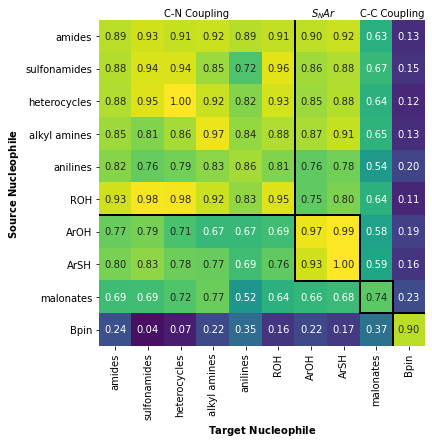

In [12]:
_, avg_aucs = performance_of_all_transfers(
            all_source_models_list, list_of_all_X_test_lists, 
            list_of_all_y_test_lists, domains, 
            all_target_arrays)

make_heatmap(domains, avg_aucs, save=True)

In [7]:
### Necessary for "model_complexity_and_transfer_performance" notebook.
#if not os.path.exists("./array_joblibs/common_Bpin_arrays.joblib"):
_, _,\
    _, target_arrays = pairwise_transfer(
                         full_id, full_desc,
                         full_yield, ["amides", "sulfonamides", "ROH", "Bpin"]
                    )
Bpin_list = []
for i in range(3):
    print(target_arrays[i][3][0].shape)
    Bpin_list.append((target_arrays[i][3][0], target_arrays[i][3][1]))
    joblib.dump(Bpin_list, "./array_joblibs/common_Bpin_arrays.joblib")

Preparing models and arrays for amides.
AUC values:  [0.931, 0.851, 0.917, 0.778, 0.833, 0.979, 0.958, 0.833, 0.892, 0.938]
average: 0.891

    124 rxns with common conditions
    112 rxns with common conditions
    50 rxns with common conditions
Preparing models and arrays for sulfonamides.
AUC values:  [0.994, 0.949, 1.0, 0.955, 0.987, 0.936, 0.936, 0.872, 0.83, 0.981]
average: 0.944

    112 rxns with common conditions
    50 rxns with common conditions
Preparing models and arrays for ROH.
AUC values:  [0.964, 0.901, 1.0, 0.918, 0.934, 0.982, 0.969, 0.962, 0.916, 0.941]
average: 0.949

    50 rxns with common conditions
Preparing models and arrays for Bpin.
AUC values:  [0.875, 0.792, 0.792, 0.854, 0.917, 1.0, 1.0, 1.0, 0.75, 1.0]
average: 0.898

(50, 73)
(50, 73)
(50, 73)
